In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import sys

sys.path.append("../EDA")
DATA_PATH = "../instruction/movieReplicationSet.csv"
ALPHA = 0.005

import movie_data_formatter as mdf
import movie_rating_gender as mrgy
import general_functions as gf

df = pd.read_csv(DATA_PATH)
df = mdf.clean_data(df)
processed_data = mdf.convert_to_table(df)
processed_data = mrgy.reformat_gender_identity(processed_data)
df_onlychild = processed_data[processed_data['are_you_an_only_child'].isin([0, 1])].dropna(subset=['rating'])

# treat rating as a categorical variable
df_onlychild['rating'] = df_onlychild['rating']


# only keep spcific columns
df_onlychild = df_onlychild[['movie_name', 'year', 'rating', 'are_you_an_only_child']]

# theme for plots
sns.set_theme(style="whitegrid", font_scale=1.1)



# What proportion of movies show an “only child effect,” meaning ratings differ between only children and those with siblings?

In [5]:
# stats
variance_table = df_onlychild.groupby(['are_you_an_only_child'])['rating'].agg(['count','mean', 'median', 'var', 'std']).reset_index()
print(variance_table)

# treat as ordinal variable
df_onlychild['rating'] = pd.Categorical(df_onlychild['rating'], ordered=True)


   are_you_an_only_child  count      mean  median       var       std
0                    0.0  91220  2.857871     3.0  1.071655  1.035208
1                    1.0  18942  2.703701     3.0  1.304644  1.142210


/var/folders/9t/kz_xx0px1mxf1wqtzvvb57fc0000gn/T/ipykernel_26887/503720562.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_onlychild.groupby(['are_you_an_only_child', 'rating'])


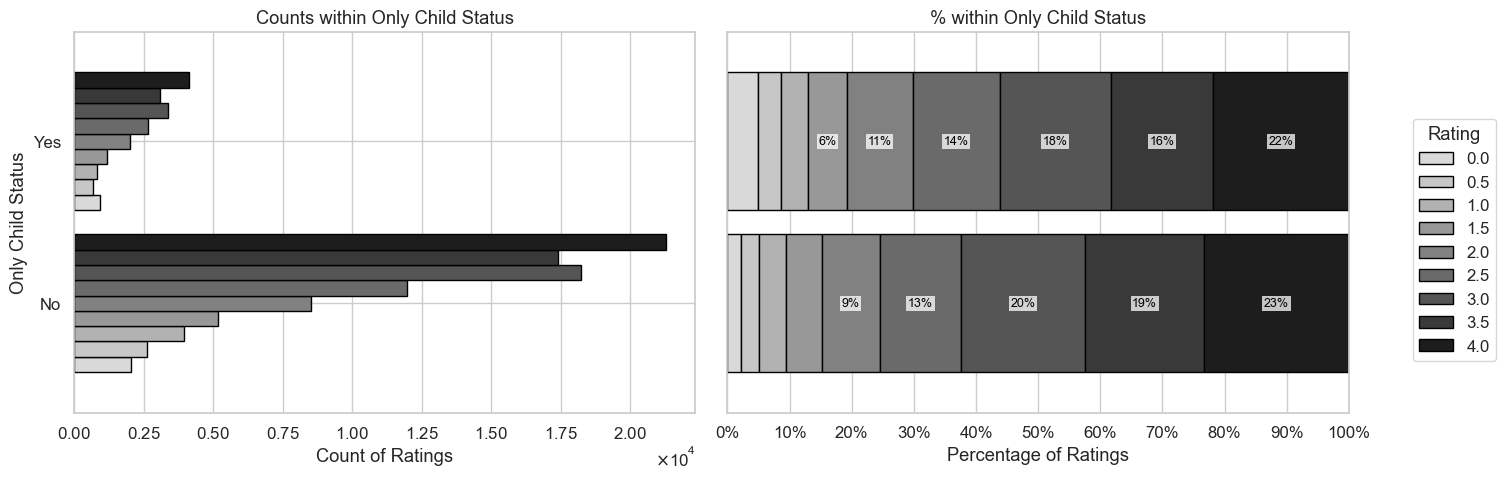

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, ScalarFormatter

# map label for only child
df_onlychild['are_you_an_only_child'] = df_onlychild['are_you_an_only_child'].map({0: 'No', 1: 'Yes'})

# counts table
rating_counts = (
    df_onlychild.groupby(['are_you_an_only_child', 'rating'])
             .size()
             .unstack(fill_value=0)
             .sort_index(axis=1)  # ensure rating columns are ordered
)

# grayscale palette (light → dark)
n_cols = rating_counts.shape[1]
greys = plt.cm.Greys(np.linspace(0.25, 0.90, n_cols))

# (optional) make sure rating columns are treated as ordered categoricals
rating_counts.columns = pd.Categorical(rating_counts.columns, ordered=True)
rating_counts = rating_counts.sort_index(axis=1)

# per-group percentages (rows sum to 1)
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0)

# overall rating shares across all genders (for the Δ labels)
overall_share = rating_counts.sum(axis=0) / rating_counts.values.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- LEFT: counts (horizontal grouped) ---
rating_counts.plot(kind='barh', ax=axes[0], width=0.85, color=greys, edgecolor='black')
axes[0].set_title('Counts within Only Child Status')
axes[0].set_xlabel('Count of Ratings')
axes[0].set_ylabel('Only Child Status')

sf = ScalarFormatter(useMathText=True)
sf.set_scientific(True)
sf.set_powerlimits((0, 0))      # always use scientific notation
axes[0].xaxis.set_major_formatter(sf)
axes[0].ticklabel_format(axis='x', style='sci', scilimits=(0,0), useMathText=True)

# --- RIGHT: % within gender (horizontal 100% stacked) ---
rating_percentages.plot(kind='barh', ax=axes[1], stacked=True, width=0.85,
                        color=greys, edgecolor='black')
axes[1].set_title('% within Only Child Status')
axes[1].set_xlabel('Percentage of Ratings')
axes[1].set_ylabel('Only Child Status')
axes[1].xaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].set_xlim(0, 1)
# step 0.1
axes[1].xaxis.set_ticks(np.arange(0, 1.1, 0.1))

# ===== In-box annotations on percentage panel =====
min_width = 0.06  # label only segments >= 6% of the row width
y_positions = np.arange(len(rating_percentages.index))
cum_left = np.zeros(len(rating_percentages), dtype=float)

for col in rating_percentages.columns:
    widths = rating_percentages[col].values                         # segment widths per gender
    centers_x = cum_left + widths / 2.0
    delta_pp = (rating_percentages[col] - overall_share[col]) * 100 # Δ vs overall in p.p.
    labels = [f"{p:,.0%}" for p, d in zip(widths, delta_pp.values)]

    for y, w, x_center, label in zip(y_positions, widths, centers_x, labels):
        if w >= min_width:
            axes[1].text(
                x_center, y, label,
                ha='center', va='center', fontsize=9, color='black',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.75, pad=1.2)
            )

    cum_left += widths

# Shared legend on the right
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(handles, labels, title='Rating', loc='center left', bbox_to_anchor=(1.01, 0.5))

# remove the y label on the right panel and the y-axis values on the left panel
axes[1].set_ylabel('')
axes[1].set_yticklabels([])


plt.tight_layout()

# save to pdf
plt.savefig('../figures/only_child_rating_distribution.pdf', bbox_inches='tight')


In [33]:
def total_variation_distance(p, q):
    print("p:", p)
    print("q:", q)
   
    # calculate total variation distance (0, 0.5, 1, 1.5, 2, ..., 4)
    bins = np.arange(0, 4.5, 0.5)
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    p = p_hist / p_hist.sum()
    q = q_hist / q_hist.sum()
    return 0.5 * np.sum(np.abs(p - q))


df_gender_movie = df_onlychild.groupby(['movie_name', 'year'])
df_gender_movie.size()

n_movies = len(df_gender_movie)

results = pd.DataFrame(columns=['prop', 'mw_p_value', 'mw_u_stat', 'ks_p_value', 'ks_stat', 'median_rating_only_child', 'median_rating_not_only_child'])

for name, group in df_gender_movie:
    movie_name = name[0] + " (" + str(name[1]) + ")"
    # drop NA ratings
    ratings = group['rating'].dropna()

    # Split ratings by only child status
    only_child_ratings = ratings[group['are_you_an_only_child'] == "Yes"]
    not_only_child_ratings = ratings[group['are_you_an_only_child'] == "No"]

    if len(only_child_ratings) > 0 and len(not_only_child_ratings) > 0:

        # check if ratings have na values
        if only_child_ratings.isna().sum() > 0 or not_only_child_ratings.isna().sum() > 0:
            print(f"NA values found in ratings for movie: {movie_name}")
            continue
        
        # Mann-Whitney U Test
        u_stat, p_value_mw = stats.mannwhitneyu(only_child_ratings, not_only_child_ratings, alternative='two-sided')
        
        # KS test
        ks_stat, p_value_ks = stats.ks_2samp(only_child_ratings, not_only_child_ratings)

        only_child = only_child_ratings.value_counts(normalize=True)
        not_only_child = not_only_child_ratings.value_counts(normalize=True)

        median_only_child = only_child_ratings.astype(float).median()
        median_not_only_child = not_only_child_ratings.astype(float).median()
        results.loc[movie_name] = [total_variation_distance(only_child, not_only_child), p_value_mw, u_stat, p_value_ks, ks_stat, median_only_child, median_not_only_child]

p: rating
4.0    0.338028
3.5    0.211268
3.0    0.169014
2.5    0.098592
1.5    0.070423
2.0    0.070423
0.5    0.028169
1.0    0.014085
0.0    0.000000
Name: proportion, dtype: float64
q: rating
4.0    0.373391
3.5    0.242489
3.0    0.178112
2.5    0.085837
2.0    0.055794
1.5    0.021459
1.0    0.019313
0.5    0.012876
0.0    0.010730
Name: proportion, dtype: float64
p: rating
2.5    0.307692
2.0    0.192308
3.0    0.153846
3.5    0.115385
0.0    0.076923
0.5    0.076923
1.0    0.038462
4.0    0.038462
1.5    0.000000
Name: proportion, dtype: float64
q: rating
2.0    0.194631
3.0    0.167785
2.5    0.140940
4.0    0.127517
1.0    0.114094
1.5    0.093960
3.5    0.067114
0.0    0.046980
0.5    0.046980
Name: proportion, dtype: float64
p: rating
4.0    0.285714
2.5    0.250000
3.5    0.142857
2.0    0.107143
0.0    0.071429
3.0    0.071429
1.0    0.035714
1.5    0.035714
0.5    0.000000
Name: proportion, dtype: float64
q: rating
2.5    0.188119
3.5    0.168317
4.0    0.168317
3.0    

In [34]:
results

,prop,mw_p_value,mw_u_stat,ks_p_value,ks_stat,median_rating_only_child,median_rating_not_only_child
10 Things I Hate About You (1999),0.0,0.246702,15182.0,0.842289,0.075682,3.50,3.5
10000 BC (2008),0.0,0.895472,1968.5,0.909873,0.112029,2.50,2.5
12 Monkeys (1995),0.0,0.360783,1572.5,0.882684,0.117397,2.75,2.5
13 Going on 30 (2004),0.0,0.138235,21954.5,0.218078,0.118849,3.00,3.0
21 Grams (2003),0.0,0.526516,311.0,0.771261,0.189459,2.00,2.5
...,...,...,...,...,...,...,...
Wing Commander (1999),0.0,0.813364,421.5,0.906592,0.151852,2.00,2.0
X-Men (2000),0.0,0.869717,21428.5,0.965050,0.054400,3.00,3.0
X-Men 2 (2003),0.0,0.790657,14665.5,0.758067,0.079083,3.00,3.0
You're Next (2011),0.0,0.832933,930.5,0.997606,0.094737,2.00,2.5


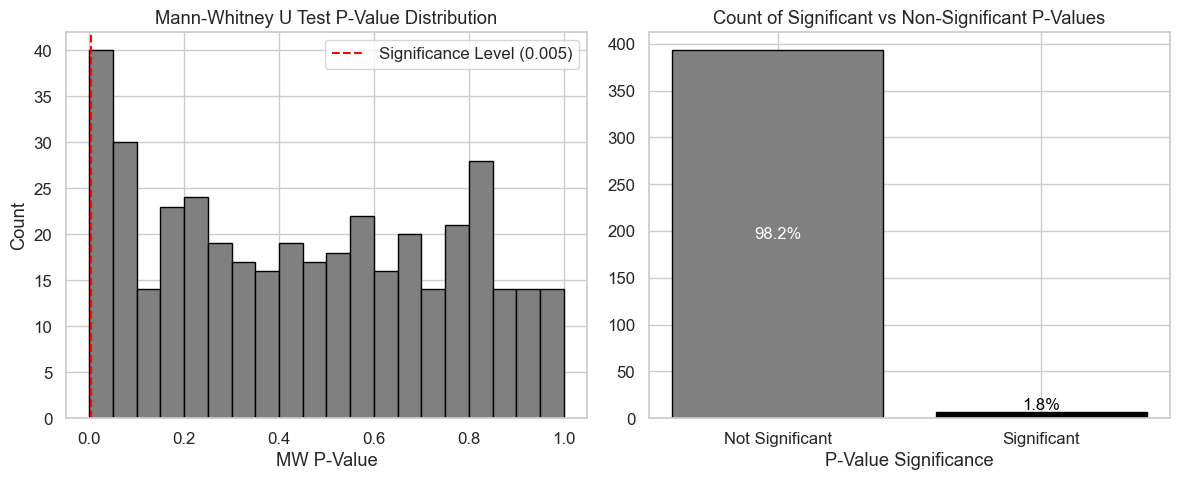

In [ ]:
# one figure 
fig, ax = plt.subplots(1,2, figsize=(12, 5), dpi=100)

# distbution of p-values
results['mw_p_value'].hist(bins=20, ax=ax[0], color='gray', edgecolor='black')
ax[0].axvline(x=ALPHA, color='red', linestyle='--', label='Significance Level ({})'.format(ALPHA))
ax[0].set_title('Mann-Whitney U Test P-Value Distribution')
ax[0].set_xlabel('MW P-Value')
ax[0].set_ylabel('Count')
ax[0].legend()

# count of significant p-values and non-significant p-values
sig = results['mw_p_value'] < ALPHA
nonsig = results['mw_p_value'] >= ALPHA
ax[1].bar(['Not Significant', 'Significant'], [nonsig.sum(), sig.sum()], color=['gray', 'black'], edgecolor='black')
ax[1].set_title('Count of Significant vs Non-Significant P-Values')
ax[1].set_xlabel('P-Value Significance')

# annotations of the % 
total = len(results)
ax[1].text(0, nonsig.sum()/2, f"{(nonsig.sum()/total)*100:.1f}%", ha='center', va='center', color='white', fontsize=12)
ax[1].text(1, sig.sum()/2 + 10, f"{(sig.sum()/total)*100:.1f}%", ha='center', va='center', color='black', fontsize=12)

plt.tight_layout()
# plt.savefig('../figures/only_child_mw_pvalue_distribution.pdf', bbox_inches='tight')
plt.show()

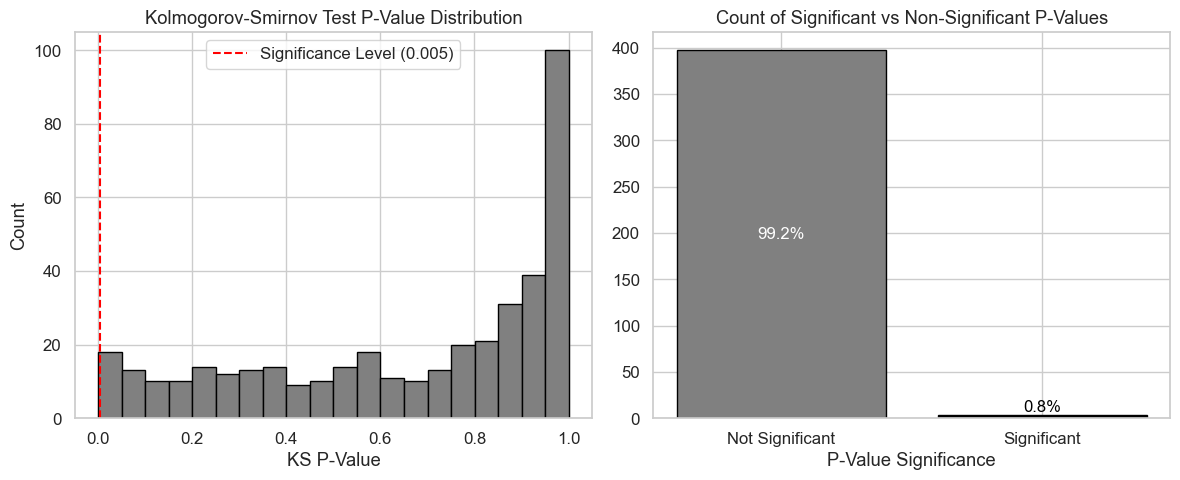

In [28]:
# one figure 
fig, ax = plt.subplots(1,2, figsize=(12, 5), dpi=100)

# distbution of p-values
results['ks_p_value'].hist(bins=20, ax=ax[0], color='gray', edgecolor='black')
ax[0].axvline(x=ALPHA, color='red', linestyle='--', label='Significance Level ({})'.format(ALPHA))
ax[0].set_title('Kolmogorov-Smirnov Test P-Value Distribution')
ax[0].set_xlabel('KS P-Value')
ax[0].set_ylabel('Count')
ax[0].legend()

# count of significant p-values and non-significant p-values
sig = results['ks_p_value'] < ALPHA
nonsig = results['ks_p_value'] >= ALPHA
ax[1].bar(['Not Significant', 'Significant'], [nonsig.sum(), sig.sum()], color=['gray', 'black'], edgecolor='black')
ax[1].set_title('Count of Significant vs Non-Significant P-Values')
ax[1].set_xlabel('P-Value Significance')

# annotations of the % 
total = len(results)
ax[1].text(0, nonsig.sum()/2, f"{(nonsig.sum()/total)*100:.1f}%", ha='center', va='center', color='white', fontsize=12)
ax[1].text(1, sig.sum()/2 + 10, f"{(sig.sum()/total)*100:.1f}%", ha='center', va='center', color='black', fontsize=12)

plt.tight_layout()
# plt.savefig('../figures/only_child_mw_pvalue_distribution.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# proportions of movies with significant differences
significant_mw = (results['mw_p_value'] < ALPHA).sum()
significant_ks = (results['ks_p_value'] < ALPHA).sum()

# avg_mw_u_stat = results['mw_u_stat'][results['mw_p_value'] < ALPHA].mean()
# median_mw_u_stat = results['mw_u_stat'][results['mw_p_value'] < ALPHA].median()

print(f"Number of movies with significant differences (Mann-Whitney U test): {significant_mw} out of {n_movies} = {significant_mw / n_movies:.2%}")
print(f"Number of movies with significant differences (Kolmogorov-Smirnov test): {significant_ks} out of {n_movies} = {significant_ks / n_movies:.2%}")

Number of movies with significant differences (Mann-Whitney U test): 7 out of 400 = 1.75%
Number of movies with significant differences (Kolmogorov-Smirnov test): 3 out of 400 = 0.75%


<function print(*args, sep=' ', end='\n', file=None, flush=False)>